In [3]:
ls

 C ����̺��� �������� �̸��� �����ϴ�.
 ���� �Ϸ� ��ȣ: 702E-35B2

 c:\Users\Sejong\Desktop\hanhwa\model ���͸�

2023-12-13  ���� 03:58    <DIR>          .
2023-12-13  ���� 07:25    <DIR>          ..
2023-11-28  ���� 11:07                 0 __init__.py
2023-11-28  ���� 11:43    <DIR>          __pycache__
2023-12-06  ���� 12:39            59,339 11_29_lstm_single.ipynb
2023-12-13  ���� 04:03           145,145 LSTM_Single_Step.ipynb
2023-12-13  ���� 06:49           270,934 transformer_multistep_prediction.ipynb
2023-12-03  ���� 06:27           168,260 transformer_singlestep_prediction.ipynb
               5�� ����             643,678 ����Ʈ
               3�� ���͸�  310,396,661,760 ����Ʈ ����


In [4]:
cd ..

c:\Users\Sejong\Desktop\hanhwa


In [5]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)
#
#print(out)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
input_window = 100
output_window = 60
batch_size = 512 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, 1, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments : 
            x : Tensor, shape : [input_window, batch_size, embedding_dim]
        """
        return x + self.pe[:x.size(0), :]
       

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask


from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

from function_file.time_series import time_series_dataframe

def get_data():
    df = time_series_dataframe()
    df = df['TEMP'].values   
    
    train_len = int(len(df) * 0.7)
    train_data = df[:train_len] 
    test_data = df[train_len:] 
    train_data = scaler_train.fit_transform(train_data.reshape(-1,1)).reshape(-1)
    test_data = scaler_test.fit_transform(test_data.reshape(-1,1)).reshape(-1)

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence.to(device), test_data.to(device)

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()

        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1:].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1:].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()

    #test_result = scaler_test.inverse_transform(test_result.reshape(-1,1)).reshape(-1)
    #truth = scaler_test.inverse_transform(truth.reshape(-1,1)).reshape(-1)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth,color="blue")
    #pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.show()
    pyplot.close()
    
    return test_result, truth, total_loss / i


def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    data, _  = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    
    data = scaler_test.inverse_transform(data.reshape(-1,1)).reshape(-1)

    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.show()
    pyplot.close()
        
# There is either an error in the loss or in the train method, but the results are different
# also to those of the predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 512
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)



#src = torch.rand(input_window, batch_size, 1) # (source sequence length,batch size,feature number) 
#out = model(src)
#
#print(out)
#print(out.shape)

# Train

In [93]:
train_data, val_data = get_data()

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
df = time_series_dataframe()
df

,TEMP,TIME,label
0,286.797,0,1
1,287.082,1,1
2,285.938,2,1
3,285.772,3,1
4,286.357,4,1
...,...,...,...
664791,865.029,664791,11
664792,864.985,664792,11
664793,865.048,664793,11
664794,865.040,664794,11


In [ ]:
plt.figure(figsize=(40,10))
sns.lineplot(x = 'TIME', y = 'TEMP', data = df[:])
plt.show()

In [171]:
train_data, val_data = get_data()
criterion = nn.MSELoss()
lr = 0.001
model = TransAm().to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 30
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if (epoch % 50 == 0):
        # epoch = 5 일 때마다 val_loss를 구하고, predict_future를 그린다.
        test_result, truth, val_loss = plot_and_loss(model, val_data)
        #predict_future(model, val_data,60)
    else:
        # epoch = 5의 배수가 아닐때마다는 evalute를 사용
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

| epoch   1 |   181/  908 batches | lr 0.001000 | 54.66 ms | loss 0.90262 | ppl     2.47
| epoch   1 |   362/  908 batches | lr 0.001000 | 52.69 ms | loss 0.00435 | ppl     1.00
| epoch   1 |   543/  908 batches | lr 0.001000 | 52.37 ms | loss 0.00135 | ppl     1.00
| epoch   1 |   724/  908 batches | lr 0.001000 | 52.31 ms | loss 0.00122 | ppl     1.00


KeyboardInterrupt: 

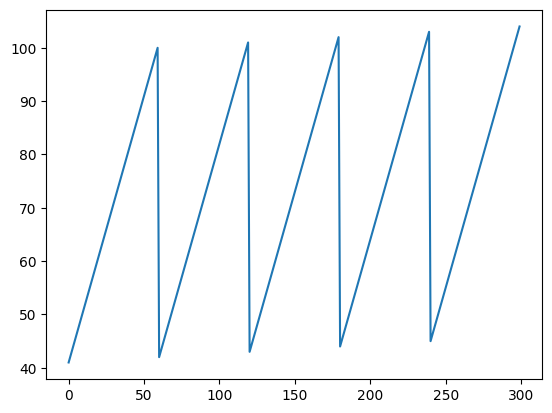

In [169]:
plt.plot(truth[:300])

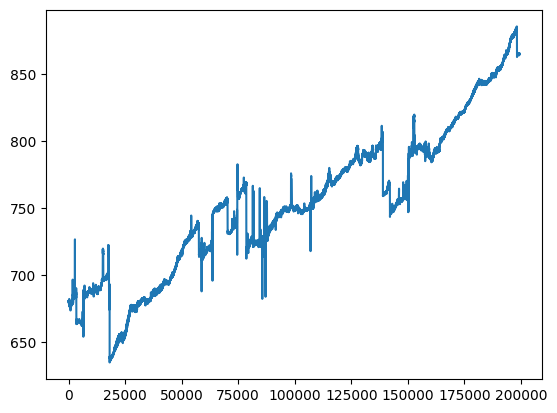

In [105]:
df = time_series_dataframe()
df = df['TEMP'].values   

train_len = int(len(df) * 0.7)

test_data = df[train_len:]

plt.plot(test_data)

In [128]:
val_data.shape

torch.Size([199279, 2, 100])

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

print("r2 : ", r2_score(truth, test_result))
print("MAE : ", mean_absolute_error(truth, test_result))
print("RMSE : ", mean_squared_error(truth, test_result)**0.5)

r2 :  0.9646204899125594
MAE :  24.151274239087517
RMSE :  29.069568074889606


###########################################################################

# 12.13

In [117]:
test_list = np.arange(1,1201)
train_len = int(len(test_list) * 0.8)
train_len

960

In [121]:
train_data = test_list[:train_len] #1 - 960
test_data = test_list[train_len:] # 961 - 1200

In [122]:
train_sequence =create_inout_sequences(train_data, input_window)
test_sequence = create_inout_sequences(test_data, input_window)

In [126]:
train_sequence = train_sequence[:-output_window]
test_sequence = test_sequence[:-output_window]

In [127]:
train_sequence = train_sequence.to(device)
test_sequence = test_sequence.to(device)

In [129]:
test_sequence.shape

torch.Size([80, 2, 100])

In [191]:
truth2 = torch.Tensor(0)
train_sequence
for i in range(len(train_sequence)-1):
    data, target = get_batch(train_sequence, i, 1)
    output = model(data)
    truth2 = torch.cat((truth2, target[-output_window:].view(-1).cpu()), 0)
print(target.shape)
truth2[-10:].view(-1)
output[-1:].view(-1).shape

torch.Size([100, 1, 1])


torch.Size([1])

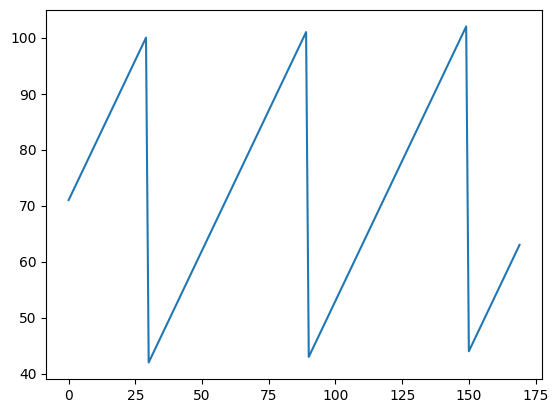

In [ ]:
plt.plot(truth2[30:200])

In [150]:
train_sequence[:, 1, -output_window:][:3].cpu().shape

torch.Size([3, 60])

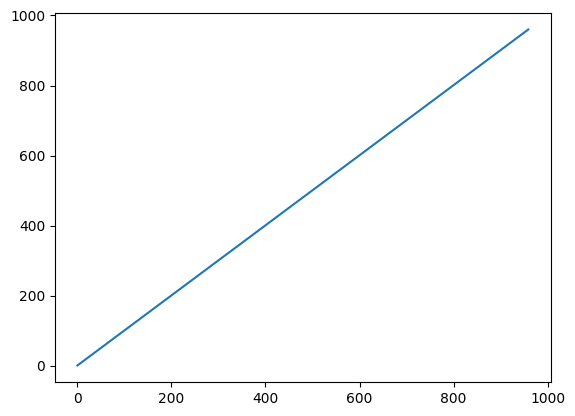

In [154]:
plt.plot(train_data)